# Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

# Итоговый проект на тему: "[Real Estate Price Prediction](https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528)"

> Студент - [Михайлов А.В.](https://geekbrains.ru/users/4305567), Kaggle User Name: avidclam, Display Name: Aleksandr Mikhailov

## Примечания:

1. Работа в итоге свелась к подбору гиперпараметров. Попытки сгенерировать "смысловые" признаки, исходя из представлений о том, какие факторы могут влиять на стоимость недвижимости, не дали ожидаемый вклад в качество модели, а в ряде случаев ухудшали её. Некоторые дополнительные признаки, тем не менее, оставлены для иллюстрации, "чтобы труд зря не пропадал".
2. Не последовал рекомендации "Повторяющиеся операции лучше оформлять в виде функций". Надеюсь, это не принципиально: аспекты автоматизации в первом учебном проекте не так важны, а наличие "самодельных" функций снижает читаемость кода.
3. В качестве модели использовал XGBoost, из учебных соображений. Обработку пропущенных значений во многом оставил на усмотрение модели.

In [1]:
from collections import defaultdict, ChainMap
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
rc_params = {'figure.figsize': [9, 5], 'lines.linewidth': 2.5}

In [3]:
matplotlib.rcParams.update(rc_params) 
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.3, rc=rc_params)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

## Импорт данных

In [5]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

In [6]:
df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
display(df.shape, test_df.shape)

(10000, 20)

(5000, 19)

## Целевая переменная

Признаки, представленные в наборе данных, обычно влияют на стоимость квадратного метра, а не на стоимость квартиры непосредственно, поэтому **в качестве целевой переменной возьмем стоимость квадратного метра**. Составляющие целевой переменной - Price и Square.

### Price - цена квартиры

In [7]:
df['Price'].isnull().value_counts()  # Пропусков нет

False    10000
Name: Price, dtype: int64

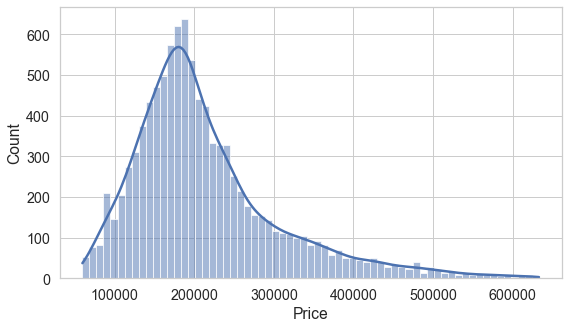

In [8]:
sns.histplot(data=df, x='Price', kde=True);

Price имеет хорошее распределение без особых неожиданностей.

### Square - площадь

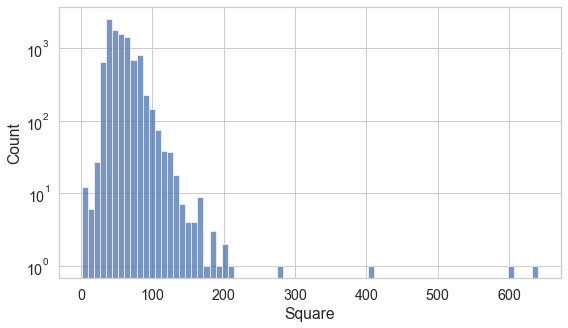

In [9]:
sns_plot = sns.histplot(data=df, x='Square', bins=75)
sns_plot.set(yscale='log');

In [10]:
df.query('Square > 200 or Square < 15')['Square'].round().value_counts().sort_index()

1.0      1
2.0      2
3.0      2
4.0      2
5.0      5
14.0     1
200.0    1
213.0    1
276.0    1
409.0    1
605.0    1
641.0    1
Name: Square, dtype: int64

Записи, в которых площадь не больше 10 и не меньше 250, считаем выбросами, остальные данные используем в модели непосредственно.

In [11]:
keep_condition = '(Square > 10 and Square < 250)'  # В этой переменной собираем условия для pd.DataFrame.query()

### Целевая переменная: Price/Square - стоимость квадратного метра

In [12]:
target = 'Price/Square'
df[target] = df['Price'] / df['Square']

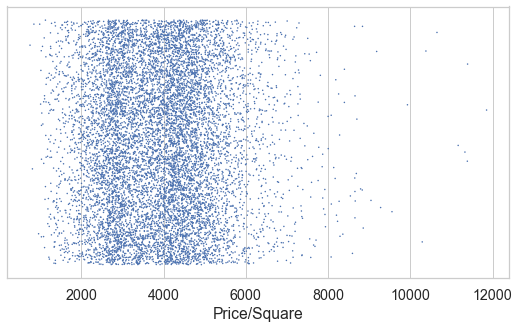

In [13]:
sns_df = df.query(keep_condition)
sns.stripplot(data=sns_df, x=target, jitter=0.45, size=1.5);  # Dot-and-Jitter Plot

Налицо двумодовое распределение без существенных аномалий.

## Признаки

In [14]:
df.columns[df.apply(lambda x: x.isnull().any())].tolist()  # У двух признаков есть пропущенные значения NaN

['LifeSquare', 'Healthcare_1']

### Id - идентификационный номер квартиры

In [15]:
df['Id'].nunique() == df.shape[0]  # Все уникальные

True

Идентификационный номер - не числовая и не категориальная переменная, пользы регрессии не приносит, в модели можно не использовать.

### DistrictId - идентификационный номер района

In [16]:
df['DistrictId'].nunique()

205

Категориальная переменная с большим количеством уровней.

In [17]:
missing_in_training = set(test_df['DistrictId'])-set(df['DistrictId'])  # В тестовых данных встретятся ID районов, которых не было в наборе данных обучения
test_df.query('DistrictId in @missing_in_training').shape[0]

8

Признак будет использован в разделе "Дополнительные вычисления".

### Rooms

Распределение записей по количеству комнат, количество и доля в промилле.

In [18]:
pd.DataFrame([df['Rooms'].astype(np.int8).value_counts(), df['Rooms'].astype(np.int8).value_counts(normalize=True) * 1000], index=['Counts', 'Normalized, ‰'])

,2,1,3,4,5,0,10,6,19
Counts,3880.0,3705.0,2235.0,150.0,18.0,8.0,2.0,1.0,1.0
"Normalized, ‰",388.0,370.5,223.5,15.0,1.8,0.8,0.2,0.1,0.1


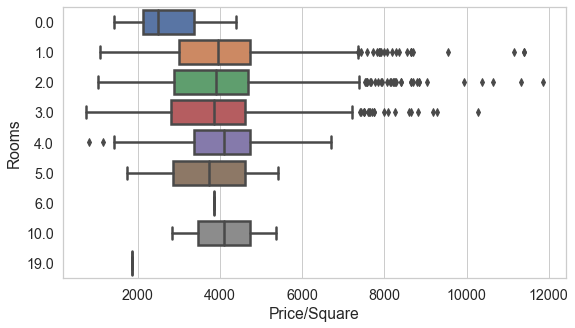

In [19]:
sns_df = df.query(keep_condition)
sns.boxplot(data=sns_df, x=target, y='Rooms', orient='h');

Имеет пропущенные значения 0 и, вероятно, выброс со значением 19. Доля аномалий в наборе данных пренебрежимо мала. Влияние на целевую переменную не заметно.

In [20]:
keep_condition = f'{keep_condition} and (Rooms > 0) and (Square / (Rooms + 2) > 7)'

### LifeSquare - жилая площадь

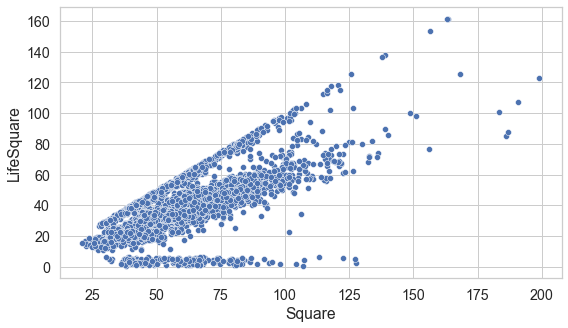

In [21]:
sns_df = df.query(keep_condition).query('LifeSquare < Square')
sns.scatterplot(data=sns_df, x='Square', y='LifeSquare');

In [22]:
lifesquare_condition = '(LifeSquare < Square * .9) and (LifeSquare > Square * .3)'
lifesquare_good_idx = df.query(keep_condition).query(lifesquare_condition).index
lifesquare_good_idx.size

6480

Много пропусков и неправдоподобных значений (> 30%).

In [23]:
df['LifeSquareClean'] = df.loc[lifesquare_good_idx, 'LifeSquare']  # Пропущенные и неправдоподобные значения в LifeSquareClean станут NaN
test_df['LifeSquareClean'] = test_df.loc[test_df.query(lifesquare_condition).index, 'LifeSquare']

### KitchenSquare - площадь кухни

In [24]:
kitchen_condition = '(KitchenSquare >= 5) and (KitchenSquare < Square * .3)'
kitchen_good_idx = df.query(keep_condition).query(kitchen_condition).index
kitchen_good_idx.shape

(6694,)

Также ~ 30% неправдоподобных значений.

In [25]:
df['KitchenSquareClean'] = df.loc[kitchen_good_idx, 'KitchenSquare']  # Пропущенные и неправдоподобные значения в KitchenSquareClean станут NaN
test_df['KitchenSquareClean'] = test_df.loc[test_df.query(kitchen_condition).index, 'KitchenSquare']

### Floor - этаж, HouseFloor - количество этажей в доме

In [26]:
np.sort(df['Floor'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [27]:
np.sort(df['HouseFloor'].unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [28]:
df.query('HouseFloor < 1 or HouseFloor > 95' )['HouseFloor'].value_counts()

0.0      269
99.0       2
117.0      1
Name: HouseFloor, dtype: int64

Признак HouseFloor содержит пропуски и выбросы, но их количество незначительно.

In [29]:
keep_condition = f'{keep_condition} and (HouseFloor > 0 and HouseFloor <= 95)'

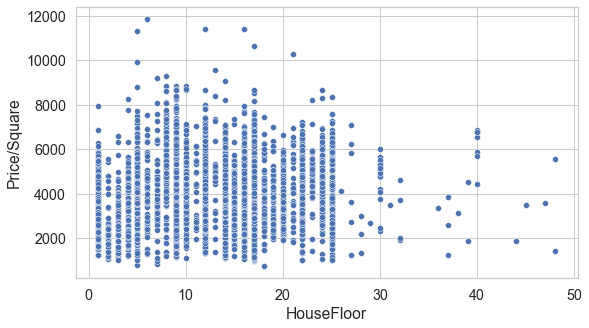

In [30]:
sns_df = df.query(keep_condition)[['HouseFloor', target]]
sns.scatterplot(data=sns_df, x='HouseFloor', y=target);

### HouseYear - год постройки дома

In [31]:
df.query('HouseYear > 2020')['HouseYear'].value_counts()

20052011    1
4968        1
Name: HouseYear, dtype: int64

In [32]:
keep_condition = f'{keep_condition} and (HouseYear <= 2020)'

Признак будет использован в разделе "Дополнительные вычисления".

### Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

In [33]:
df.query(keep_condition)[['Ecology_2', 'Ecology_3' ]].value_counts(normalize=True)

Ecology_2  Ecology_3
B          B            0.961808
           A            0.028282
A          B            0.009909
dtype: float64

Влияние Ecology_2 и Ecology_3 мало из-за того, что более 96% значений имеют одинаковое сочетание значений Ecology_2 и Ecology_3.

Характер влияния Ecology_1 не очевиден.

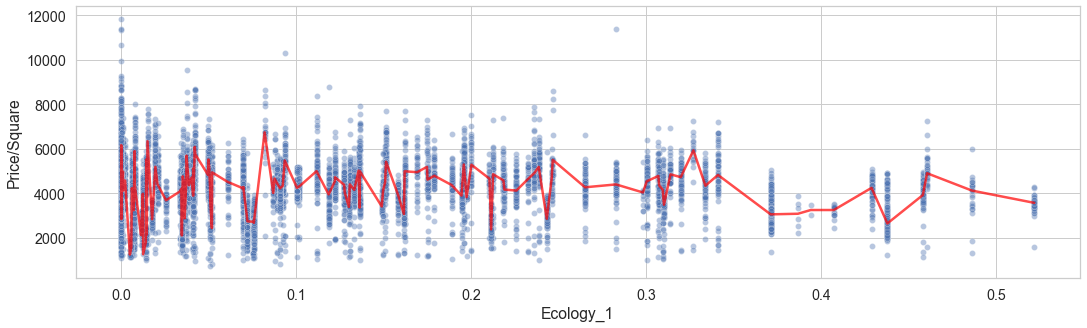

In [34]:
sns_df = df.query(keep_condition)[['Ecology_1', target]]
snsplot = sns.scatterplot(data=sns_df, x='Ecology_1', y=target, alpha=0.4)
snsplot.figure.set_size_inches((18, 5))
sns_df = sns_df.groupby('Ecology_1').agg({target: np.median}).reset_index()
sns.lineplot(data=sns_df, x='Ecology_1', y=target, alpha=0.7, color='red');

### Social_1, Social_2, Social_3 - социальные показатели местности

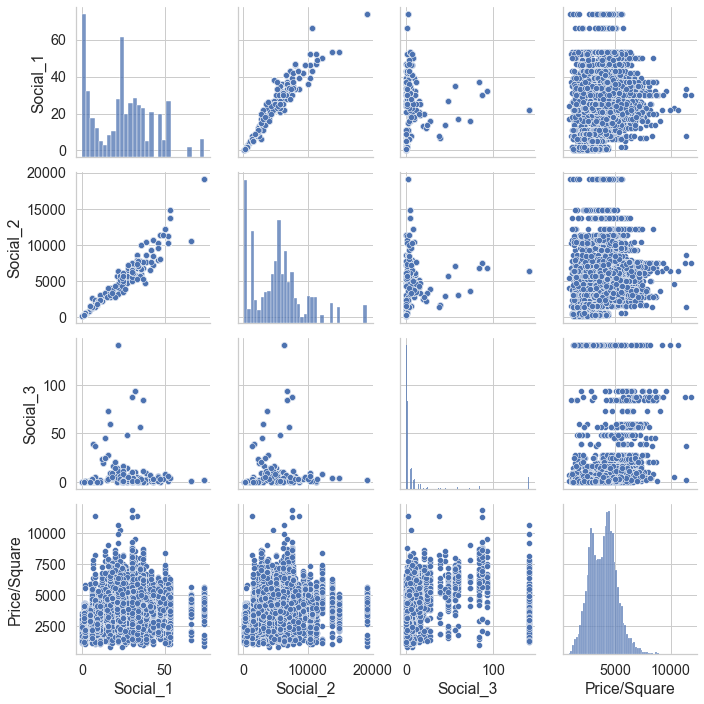

In [35]:
sns_df = df.query(keep_condition)[['Social_1', 'Social_2', 'Social_3', target]]
sns.pairplot(sns_df);

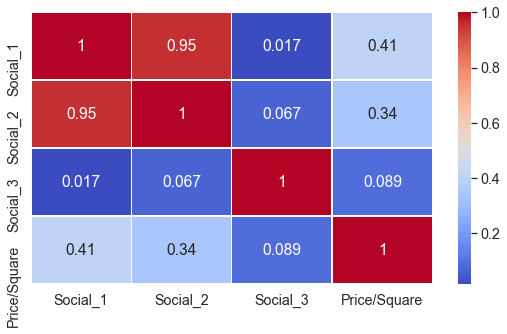

In [36]:
sns.heatmap(sns_df.corr(), annot=True, linewidths=.5, cmap='coolwarm');

Social_1 и Social_2 очень сильно коррелированы. Из двух используем Social_1.

### Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

In [37]:
df['Healthcare_1'].isnull().value_counts(normalize=True)

False    0.5202
True     0.4798
Name: Healthcare_1, dtype: float64

У `Healthcare_1` значительный процент пропущенных значений.

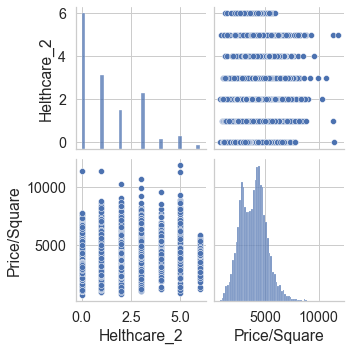

In [38]:
sns_df = df.query(keep_condition)[['Helthcare_2', target]]
sns.pairplot(sns_df);

Признак Helthcare_2 будет использован в разделе "Дополнительные вычисления".

### Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

In [39]:
df.query(keep_condition)['Shops_2'].value_counts()

B    8958
A     730
Name: Shops_2, dtype: int64

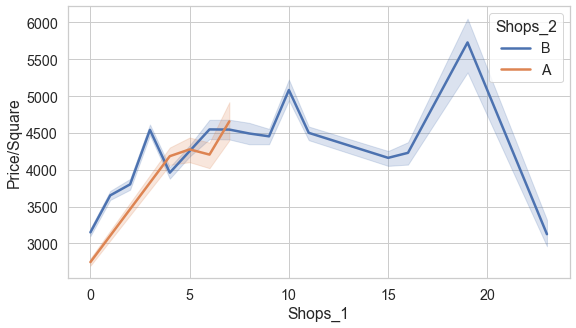

In [40]:
sns_df = df.query(keep_condition)[['Shops_1', 'Shops_2', target]]
sns.lineplot(data=sns_df, x='Shops_1', y=target, hue='Shops_2');

## Дополнительные вычисления и признаки

### На базе DistrictID

Району сопоставим его "масштаб": округленный вниз до целого логарифм количества записей в районе.

In [41]:
district_scale_translate = defaultdict(int)
district_scale_translate.update(
    df
    .query(keep_condition)[['DistrictId']]
    .groupby('DistrictId')
    .agg(DistrictCount = ('DistrictId', 'count'))
    ['DistrictCount']
    .apply(np.log)
    .astype(np.int8)
    .to_dict()
)
df['DistrictScale'] = df['DistrictId'].replace(district_scale_translate)
test_df['DistrictScale'] = test_df['DistrictId'].replace(district_scale_translate)

### На базе HouseYear

Год постройки дома влияет на распределение целевой переменной. Закодируем период постройки дома медианой целевой переменной.

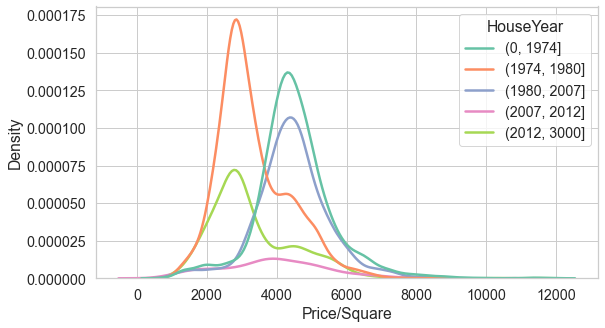

In [42]:
sns_df = df.query(keep_condition)
house_year_bins = (0, 1974, 1980, 2007, 2012, 3000)
sns.kdeplot(data=sns_df, x=target, hue=pd.cut(sns_df['HouseYear'], bins=house_year_bins), palette='Set2');

In [43]:
house_year_target_translate = defaultdict(lambda: len(house_year_bins) - 2)  # Дома, у которых не определился период, попадут в последнюю группу
label_dict = (
    pd.DataFrame(
        {'labels': pd.cut(df.query(keep_condition)['HouseYear'], bins=house_year_bins, labels=False),
         'target': df.query(keep_condition)[target]})
    .groupby('labels')
    .agg({'target': np.median})
    ['target']
    .to_dict()
)
house_year_target_translate.update(label_dict)

df['HouseYearTarget'] = pd.cut(df['HouseYear'], bins=house_year_bins, labels=False).replace(house_year_target_translate)
test_df['HouseYearTarget'] = pd.cut(test_df['HouseYear'], bins=house_year_bins, labels=False).replace(house_year_target_translate)

### На базе Helthcare_2

Заменим значение Helthcare_2 медианой целевой переменной.

In [44]:
hc2_dict = (
    df
    .query(keep_condition)
    .filter(['Helthcare_2', target])
    .groupby('Helthcare_2')
    .agg(target = (target, np.median))
    ['target']
    .to_dict()
)

df['HC2Target'] = df['Helthcare_2'].replace(hc2_dict)
test_df['HC2Target'] = test_df['Helthcare_2'].replace(hc2_dict)

## Подготовленные наборы данных

In [45]:
train_df = df.query(keep_condition).copy()
train_target_df = df.query(keep_condition).filter(['Square', target, 'Price']).copy()
# test_df не меняется

In [46]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Price/Square',
       'LifeSquareClean', 'KitchenSquareClean', 'DistrictScale',
       'HouseYearTarget', 'HC2Target'],
      dtype='object')

## Модель

In [47]:
use_features = [
    'Square', 'DistrictScale', 'LifeSquareClean', 'KitchenSquareClean', 'HouseFloor', 
    'HouseYear', 'HouseYearTarget', 'Ecology_1', 'Social_1', 'Social_2', 
    'Healthcare_1', 'HC2Target', 'Shops_1'
]

### Custom model class

Поскольку в модели выбрана целевая переменная Price/Square, а для финального предсказания и анализа качества модели нужна Price, придется сделать "обертку" для класса модели.

In [48]:
class XGBRegressorWrapper(xgb.XGBRegressor):
    def fit(self, *args, **kwargs):
        # Решение не совсем production, но для ноутбука подойдет
        fit_X = kwargs.pop('X', args[0])
        fit_y = kwargs.pop('y', args[1])
        return super().fit(fit_X, fit_y / fit_X['Square'], *args[2:], **kwargs)
       
    def predict(self, *args, **kwargs):
        predict_data = kwargs.get('data', args[0])
        return super().predict(*args, **kwargs) * predict_data['Square']

### Подбор гиперпараметров

In [49]:
fixed_parameters = {'booster': 'gbtree', 'tree_method': 'hist', 'importance_type': 'total_gain', 'reg_lambda': 30}

Код GridSearchCV ниже "закомментирован" raw, чтобы не срабатывал при каждом запуске.

In [50]:
grid_parameters_selected = {
    'learning_rate': 0.07,
    'n_estimators': 170,
    'max_depth': 9,
    'colsample_bytree': 1,
    'colsample_bynode': 0.4
}
model_parameters = ChainMap(fixed_parameters, grid_parameters_selected)

### Модель и метрика на training данных

Проверим работу модели в выбранными параметрами на Training данныех. Чтобы не путаться, тренинговую часть тренингового набора данных будем называть learn, а тестовую - valid.

In [51]:
X_learn, X_valid, y_learn, y_valid = train_test_split(train_df.filter(use_features), train_target_df['Price'], test_size=0.33, random_state=7)
final_model = XGBRegressorWrapper(**model_parameters)
final_model.fit(X_learn, y_learn);

In [52]:
# Метрика Learn
price_pred = final_model.predict(X_learn)
r2_score(y_learn, price_pred)

0.8980532127396108

In [53]:
# Метрика Valid
price_pred = final_model.predict(X_valid)
r2_score(y_valid, price_pred)

0.7405393875906154

In [54]:
pd.DataFrame(final_model.feature_importances_, index=final_model.get_booster().feature_names, columns=['Importance']).sort_values(by='Importance', ascending=False)

,Importance
DistrictScale,0.252491
Social_2,0.147738
LifeSquareClean,0.118039
Social_1,0.106141
Ecology_1,0.068437
Square,0.062121
Healthcare_1,0.046360
HouseYear,0.044094
HouseFloor,0.041802
KitchenSquareClean,0.034463


### Модель на всех training данных, предсказанные данные test

In [55]:
final_model.fit(train_df.filter(use_features), train_target_df['Price'])
test_df['Price'] = final_model.predict(test_df.filter(use_features)).round(2)

In [56]:
test_df[['Id', 'Price']].to_csv('avidclam_submit.csv', index=False)

Leaderboard: 0.73929